# utils and libraries

In [88]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy as sp

from matplotlib import pylab as plt

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Activation, Dense, Merge

from utils.data import load_data, train_test_split, _stratified_shuffle
from utils.pass_quality import approx_pq, pass_quality

from utils.utils import *

from keras.objectives import MSE
import theano.tensor as tt

%matplotlib inline

# data

### loading

In [2]:
data = load_data(shuffle=True)

data['y'] = data.ref_pass
data['y_lab'] = data['pass.1']
# data.drop(['ref_pass', 'frame_num', 'cam_num', 'cam_num.1', 'pass'], axis=1, inplace=True)
data.drop(['ref_pass', 'frame_num', 'cam_num', 'cam_num.1', 'loop.1', 'loop', 'pass', 'pass.1'], axis=1, inplace=True)

3605


In [3]:
data = data[['cor', 'shield', 'cor.1', 'shield.1', 'y', 'y_lab']]

### splitting:

In [4]:
# if try only .1 signal:
# data = data[['cor.1', 'loop.1', 'shield.1', 'y', 'y_lab']]

In [8]:
test_size = 0.25

X_train, X_test, y_train, y_test, y_train_lab, y_test_lab = train_test_split(data, n_prev=7, test_size=test_size)

### the pass_quality benchmark without and with morphological filter:

In [9]:
# without:
print approx_pq(y_train, y_train_lab)[:-1]
# with:
print approx_pq(y_train, morphological_filter(y_train_lab, 5))[:-1]

(0.76991328896846178, 3818.0000000099999, 1141.00000001)
(0.81766441821113967, 3879.0000000099999, 865.00000001)


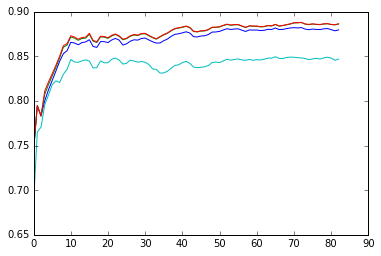

In [7]:
plot_pq(y_train, morphological_filter(y_train_lab, 1))
plot_pq(y_train, morphological_filter(y_train_lab, 3))
plot_pq(y_train, morphological_filter(y_train_lab, 5)) # 5 and 7 give
# plot_pq(y_train, morphological_filter(y_train_lab, 7)) # almost the same results
plot_pq(y_train, y_train_lab)

# RNN model architecture

In [10]:
encoder_a = Sequential()
encoder_a.add(LSTM(input_dim=X_train.shape[2] / 2, output_dim=8, return_sequences=False))

encoder_b = Sequential()
encoder_b.add(LSTM(input_dim=X_train.shape[2] / 2, output_dim=8, return_sequences=False))

decoder = Sequential()
decoder.add(Merge([encoder_a, encoder_b], mode='concat'))
decoder.add(Dense(8, activation='tanh'))

decoder.add(Dense(1, activation='tanh'))

decoder.compile(loss='MSE',
                optimizer='rmsprop')

In [11]:
def regularized_mse(y_true, y_pred):
    # compute Mean Squared Error:
    mean_squared_error = MSE(y_true, y_pred)

    mean_squared_gradient = tt.mean((tt.extra_ops.diff(y_pred.T[-1].T)) ** 2)

    return mean_squared_error * (17. / 20) + mean_squared_gradient * (3. / 20)

In [12]:
# or with regularized_mse loss
#model.compile(optimizer='rmsprop', loss='MSE')

# model fitting

In [16]:
decoder.fit([X_train.T[:2].T, X_train.T[2:].T],
          y_train, 
          batch_size=1024, 
          nb_epoch=20, 
          shuffle=False,
          sample_weight=init_weights(y_train))

Epoch 1/20
85926/85926 [==============================] - 11s - loss: 0.1116    
Epoch 2/20
85926/85926 [==============================] - 11s - loss: 0.1019    
Epoch 3/20
85926/85926 [==============================] - 11s - loss: 0.1003    
Epoch 4/20
85926/85926 [==============================] - 11s - loss: 0.0993    
Epoch 5/20
85926/85926 [==============================] - 11s - loss: 0.0986    
Epoch 6/20
85926/85926 [==============================] - 14s - loss: 0.0981    
Epoch 7/20
85926/85926 [==============================] - 13s - loss: 0.0978    
Epoch 8/20
85926/85926 [==============================] - 12s - loss: 0.0975    
Epoch 9/20
85926/85926 [==============================] - 13s - loss: 0.0973    
Epoch 10/20
85926/85926 [==============================] - 11s - loss: 0.0970    
Epoch 11/20
85926/85926 [==============================] - 13s - loss: 0.0968    
Epoch 12/20
85926/85926 [==============================] - 13s - loss: 0.0966    
Epoch 13/20
85926/85926 [

KeyboardInterrupt: 

In [17]:
decoder.evaluate([X_train.T[:2].T, X_train.T[2:].T], y_train, batch_size=1024)

85926/85926 [==============================] - 0s     


0.15774606618603368

# postprocessing:

In [56]:
model = decoder

In [57]:
result = sp.optimize.minimize_scalar(model_pq, bounds=[0.3, 0.95], args=([X_train.T[:2].T, X_train.T[2:].T], y_train, model), method='bounded')
print result.x

0.512060306871


In [114]:
y_pred = (decoder.predict([X_test.T[:2].T, X_test.T[2:].T], batch_size=1024) > 0.49).astype(int).flatten()

In [115]:
#print approx_pq(y_test[:], morphological_filter(y_pred[:], 0))[:-1]
#print approx_pq(y_test[:], morphological_filter(y_pred[:], 3))[:-1]
print pass_quality(y_test[:], morphological_filter(y_pred[:], 5))

0.875080906149


In [80]:
accuracy_score(y_test, morphological_filter(y_pred, 3))

0.76211761419192625

In [87]:
accuracy_score(y_train, morphological_filter(y_pred, 3))

0.77759932965575029

In [89]:
pass_quality(y_train, morphological_filter(y_pred, 3))

0.8955926401369276

In [81]:
y_pred = (decoder.predict([X_train.T[:2].T, X_train.T[2:].T], batch_size=1024) > result.x).astype(int).flatten()

In [68]:
print approx_pq(y_train[:], morphological_filter(y_pred[:], 0))[:-1]
print approx_pq(y_train[:], morphological_filter(y_pred[:], 3))[:-1]
print approx_pq(y_train[:], morphological_filter(y_pred[:], 5))[:-1]

(0.68182604184616347, 3943.0000000099999, 1840.00000001)
(0.78651048554586622, 4163.0000000099999, 1130.00000001)
(0.78651048554586622, 4163.0000000099999, 1130.00000001)


In [69]:
print approx_pq(y_test, morphological_filter(y_test_lab, 0))[:-1]
print approx_pq(y_test, morphological_filter(y_test_lab, 3))[:-1]
print approx_pq(y_test, morphological_filter(y_test_lab, 5))[:-1]

(0.78897933625186001, 1260.0000000099999, 337.00000001)
(0.81853281852871906, 1272.0000000099999, 282.00000001)
(0.81853281852871906, 1272.0000000099999, 282.00000001)


In [45]:
print approx_pq(y_train, morphological_filter(y_train_lab, 0))[:-1]
print approx_pq(y_train, morphological_filter(y_train_lab, 3))[:-1]
print approx_pq(y_train, morphological_filter(y_train_lab, 5))[:-1]

(0.8529789969995714, 3980, 686)
(0.8886177057909918, 4005, 502)
(0.8896046201688138, 4005, 497)
